In [19]:
import pandas as pd
import tkinter as tk
from tkinter import ttk
from tkinter import Listbox
from tkinter import Label
from tkinter import Button
from tkinter import Entry
from tkcalendar import DateEntry
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from pandastable import Table, TableModel
import statsmodels.api as sm
from datetime import datetime
import numpy as np
import requests
import zipfile
import io
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Data Ingest and Preprocessing

In [2]:
col_names = ['RECORD_ID','CAMPNO','MAKETXT','MODELTXT','YEARTXT','MFGCAMPNO','COMPNAME','MFGNAME','BGMAN','ENDMAN','RCLTYPECD','POTAFF','ODATE','INFLUENCED_BY','MFGTXT','RCDATE','DATEA','RPNO','FMVAA','DESC_DEFECT','CONEQUENCE_DEFECT','CORRECTIVE_ACTION','NOTES','RCL_CMPT_ID','MFR_COMP_NAME','MFR_COMP_DESC','MFR_COMP_PTNO']

In [3]:
# URL of the FLAT_RCL.zip file
url = 'https://static.nhtsa.gov/odi/ffdd/rcl/FLAT_RCL.zip'

# Send a GET request to download the zip file
response = requests.get(url)

# Extract the contents of the zip file
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
file_name = zip_file.namelist()[0]  # Assumes there is only one file in the zip
zip_file.extractall()

# Read the FLAT_RCL.txt file into a DataFrame
data = pd.read_csv(file_name, delimiter='\t', error_bad_lines=False, header=None, names = col_names)

C:\Users\ryanp\AppData\Local\Temp\ipykernel_49260\4019005048.py:13: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_name, delimiter='\t', error_bad_lines=False, header=None, names = col_names)
Skipping line 188398: expected 27 fields, saw 34

C:\Users\ryanp\AppData\Local\Temp\ipykernel_49260\4019005048.py:13: DtypeWarning: Columns (17,18,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_name, delimiter='\t', error_bad_lines=False, header=None, names = col_names)


In [4]:
def convert_date_string(date_string):
    date_obj = datetime.strptime(date_string, "%Y%m%d")
    formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date

# Apply the function to the 'date_string' column
data['DATEA'] = data['DATEA'].astype(str).apply(convert_date_string)

In [5]:
data['DATEA'] = pd.to_datetime(data['DATEA'], format='%Y-%m-%d')

In [37]:
makes = ['BMW','NISSAN','INFINITI','VOLVO','TOYOTA','MINI','AUDI','KIA','HONDA','MOPAR','MERCEDES','VOLKSWAGEN','MAZDA','JAGUAR','SUBARU','LEXUS','HYUNDAI','LAND ROVER','ACURA','PORSCHE']
relevant_data = data[data['MAKETXT'].isin(makes)].reset_index()

In [62]:
relevant_data = relevant_data.replace(np.nan,0)
relevant_data['MFGCAMPNO'] = relevant_data['MFGCAMPNO'].astype(str)
relevant_data = relevant_data[relevant_data['DATEA'] > '1980-01-01']

## Data Visualization

### Basic Summaries

In [63]:
# Drop duplicate rows based on the 'MAKETXT' and 'CAMPNO' columns
unique_data = relevant_data.drop_duplicates(subset=['MAKETXT', 'CAMPNO'])

# Summarize trends for each manufacturer
manufacturer_campaign_counts = unique_data.groupby('MAKETXT')['CAMPNO'].nunique()
manufacturer_vehicle_counts = unique_data.groupby('MAKETXT')['POTAFF'].sum()

In [64]:
# Summary of campaign counts
print("Campaign Counts:")
print(manufacturer_campaign_counts)

# Summary of vehicle counts
print("Vehicle Counts:")
print(manufacturer_vehicle_counts)

Campaign Counts:
MAKETXT
ACURA         121
AUDI          209
BMW           468
HONDA         382
HYUNDAI       244
INFINITI      106
JAGUAR        111
KIA           158
LAND ROVER    140
LEXUS         102
MAZDA         207
MERCEDES        1
MINI           39
MOPAR          31
NISSAN        349
PORSCHE       148
SUBARU        165
TOYOTA        364
VOLKSWAGEN    301
VOLVO         333
Name: CAMPNO, dtype: int64
Vehicle Counts:
MAKETXT
ACURA         41664286.0
AUDI          10038902.0
BMW           13267713.0
HONDA         69524112.0
HYUNDAI       23531333.0
INFINITI      17543575.0
JAGUAR          873760.0
KIA           12007866.0
LAND ROVER     2097542.0
LEXUS         27636079.0
MAZDA         25725881.0
MERCEDES         16270.0
MINI            643739.0
MOPAR           268085.0
NISSAN        40959536.0
PORSCHE        1335726.0
SUBARU        14609871.0
TOYOTA        68355105.0
VOLKSWAGEN    18377680.0
VOLVO          5972769.0
Name: POTAFF, dtype: float64


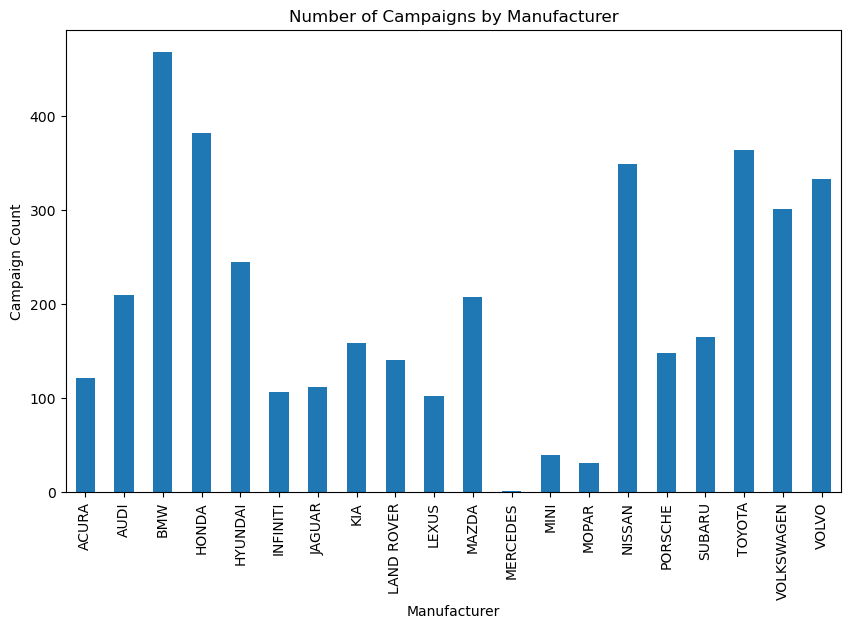

In [66]:
# Bar chart of campaign counts by manufacturer
plt.figure(figsize=(10, 6))
manufacturer_campaign_counts.plot(kind='bar')
plt.title('Number of Campaigns by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Campaign Count')
plt.show()

In [67]:
# Calculate summary statistics
max_count = manufacturer_campaign_counts.max()
min_count = manufacturer_campaign_counts.min()
avg_count = manufacturer_campaign_counts.mean()

# Get manufacturers with the most and least campaign counts
manufacturer_most = manufacturer_campaign_counts.idxmax()
manufacturer_least = manufacturer_campaign_counts.idxmin()

# Create a formatted string for the summary statistics
summary = f"Summary Statistics:\n" \
          f"------------------------------\n" \
          f"Manufacturer with the most campaigns: {manufacturer_most}\n" \
          f"Manufacturer with the least campaigns: {manufacturer_least}\n" \
          f"Maximum campaign count: {max_count}\n" \
          f"Minimum campaign count: {min_count}\n" \
          f"Average campaign count: {avg_count}"

# Print the summary statistics
print(summary)

Summary Statistics:
------------------------------
Manufacturer with the most campaigns: BMW
Manufacturer with the least campaigns: MERCEDES
Maximum campaign count: 468
Minimum campaign count: 1
Average campaign count: 198.95


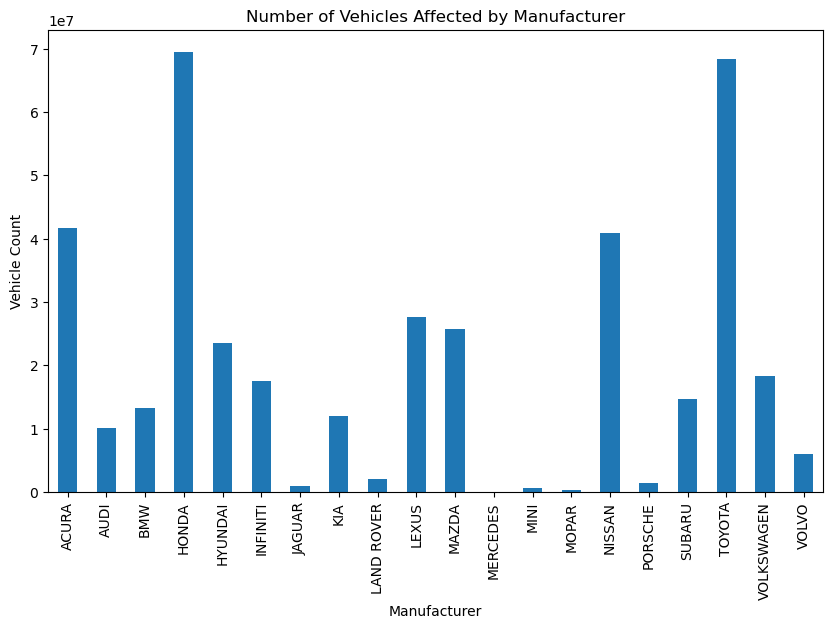

In [68]:
# Bar chart of vehicle counts by manufacturer
plt.figure(figsize=(10, 6))
manufacturer_vehicle_counts.plot(kind='bar')
plt.title('Number of Vehicles Affected by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Vehicle Count')
plt.show()

In [70]:
# Calculate summary statistics
max_vehicle_count = manufacturer_vehicle_counts.max()
min_vehicle_count = manufacturer_vehicle_counts.min()
avg_vehicle_count = manufacturer_vehicle_counts.mean()

# Get manufacturers with the most and least vehicle counts
manufacturer_most_vehicles = manufacturer_vehicle_counts.idxmax()
manufacturer_least_vehicles = manufacturer_vehicle_counts.idxmin()

# Create a formatted string for the summary statistics
summary_vehicles = f"Summary Statistics (Vehicles):\n" \
                   f"------------------------------\n" \
                   f"Manufacturer with the most vehicles affected: {manufacturer_most_vehicles}\n" \
                   f"Manufacturer with the least vehicles affected: {manufacturer_least_vehicles}\n" \
                   f"Maximum vehicle count: {max_vehicle_count}\n" \
                   f"Minimum vehicle count: {min_vehicle_count}\n" \
                   f"Average vehicle count: {avg_vehicle_count}"

# Print the summary statistics
print(summary_vehicles)

Summary Statistics (Vehicles):
------------------------------
Manufacturer with the most vehicles affected: HONDA
Manufacturer with the least vehicles affected: MERCEDES
Maximum vehicle count: 69524112.0
Minimum vehicle count: 16270.0
Average vehicle count: 19722491.5


### Time Series and Trend Summaries

#### All Manufacturers: Number of Campaigns

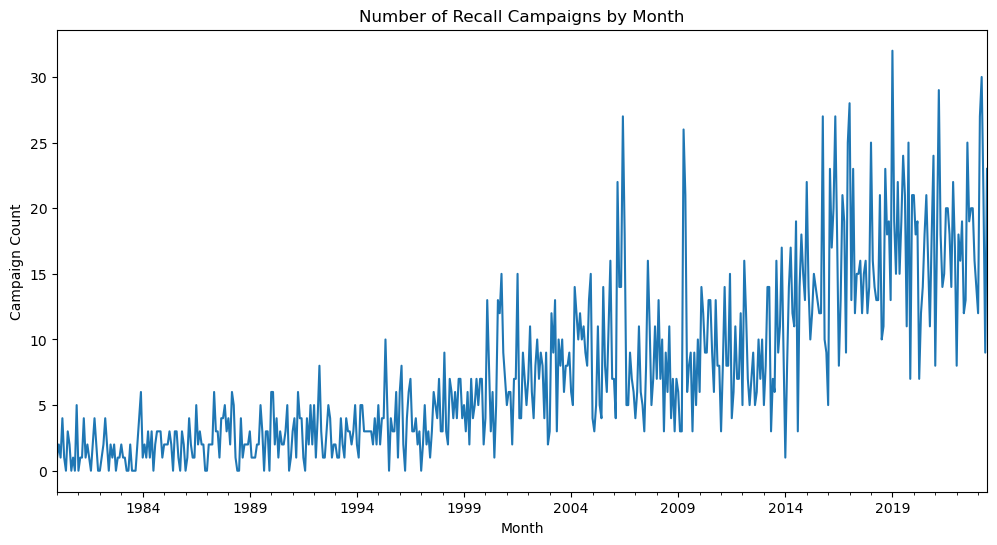

In [71]:
# Group by month and count the number of recall campaigns
campaigns_by_month = unique_data.groupby(pd.Grouper(key='DATEA', freq='M')).size()

# Plot the time series of recall campaigns
plt.figure(figsize=(12, 6))
campaigns_by_month.plot()
plt.title('Number of Recall Campaigns by Month')
plt.xlabel('Month')
plt.ylabel('Campaign Count')
plt.show()

In [73]:
# Calculate summary statistics
max_campaign_count = campaigns_by_month.max()
min_campaign_count = campaigns_by_month.min()
avg_campaign_count = campaigns_by_month.mean()
total_campaign_count = campaigns_by_month.sum()

# Get the month with the most and least recall campaigns
month_most_campaigns = campaigns_by_month.idxmax().strftime('%B %Y')
month_least_campaigns = campaigns_by_month.idxmin().strftime('%B %Y')

# Create a formatted string for the summary statistics
summary_campaigns = f"Summary Statistics (Recall Campaigns):\n" \
                    f"-----------------------------------\n" \
                    f"Month with the most recall campaigns: {month_most_campaigns}\n" \
                    f"Month with the least recall campaigns: {month_least_campaigns}\n" \
                    f"Maximum active campaign count: {max_campaign_count}\n" \
                    f"Minimum active campaign count: {min_campaign_count}\n" \
                    f"Average active campaign count: {avg_campaign_count}\n" \
                    f"Total campaign count: {total_campaign_count}"

# Print the summary statistics
print(summary_campaigns)

Summary Statistics (Recall Campaigns):
-----------------------------------
Month with the most recall campaigns: January 2019
Month with the least recall campaigns: June 1980
Maximum active campaign count: 32
Minimum active campaign count: 0
Average active campaign count: 7.6226053639846745
Total campaign count: 3979


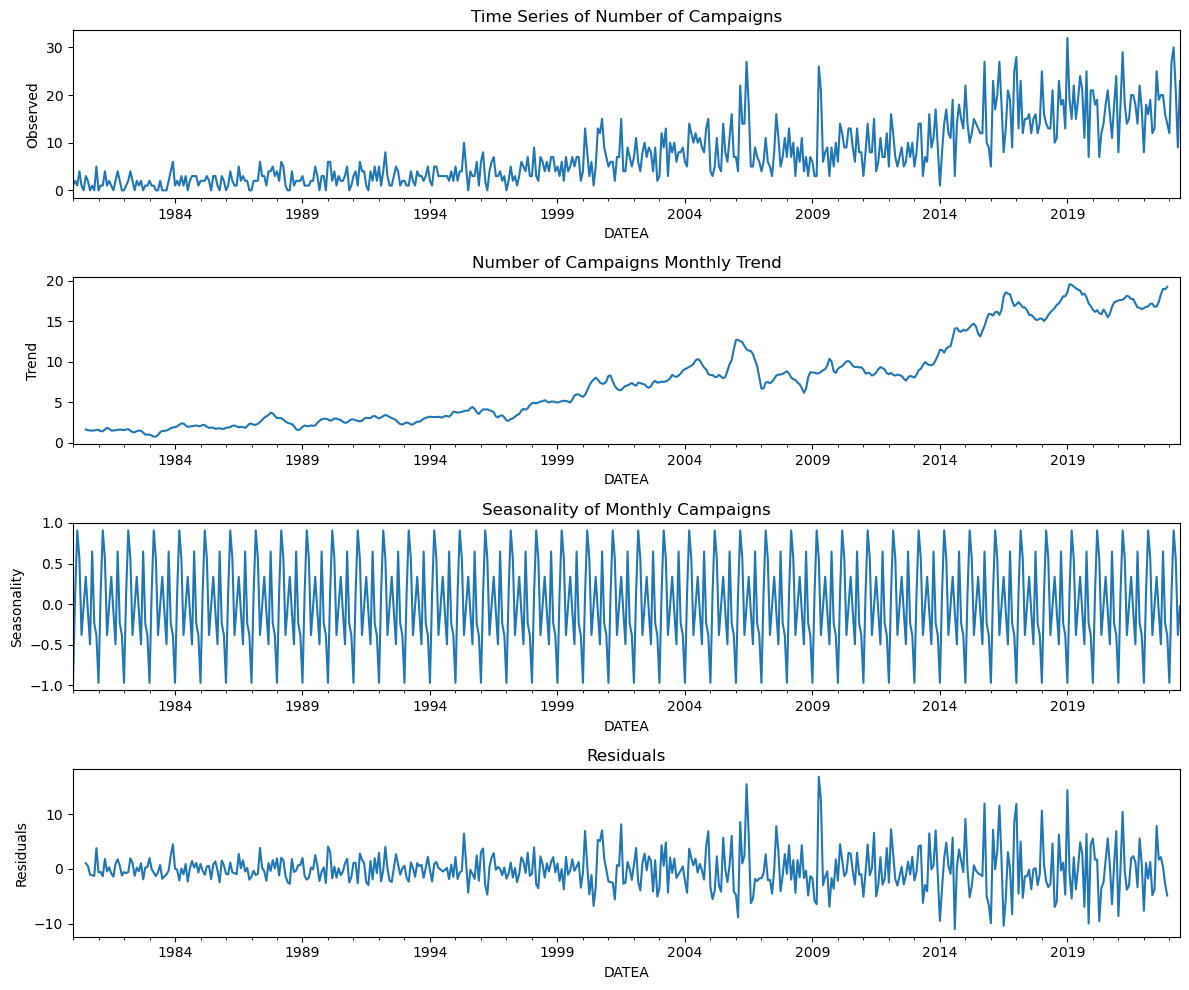

In [74]:
# Perform time series decomposition (trend, seasonality, and residuals)
decomposition = sm.tsa.seasonal_decompose(campaigns_by_month, model='additive')

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_title('Time Series of Number of Campaigns')
decomposition.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
axes[1].set_title('Number of Campaigns Monthly Trend')
decomposition.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonality')
axes[2].set_title('Seasonality of Monthly Campaigns')
decomposition.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residuals')
axes[3].set_title('Residuals')

plt.tight_layout()
plt.show()

In [92]:
# Calculate summary statistics for the trend component
max_trend = decomposition.trend.max()
min_trend = decomposition.trend.min()
avg_trend = decomposition.trend.mean()
first_non_nan_index = next((i for i, x in list(enumerate(decomposition.trend)) if not np.isnan(x)), None)
last_non_nan_index = next((i for i, x in reversed(list(enumerate(decomposition.trend))) if not np.isnan(x)), None)
first_trend = decomposition.trend.iloc[last_non_nan_index-6] if len(decomposition.trend) > 6 else decompositions.trend.iloc[first_non_nan_index]
last_trend = decomposition.trend.iloc[last_non_nan_index]
trend_direction = "Upwards" if last_trend > first_trend else "Downwards"

# Create a formatted string for the summary statistics
summary_time_series = f"Six Month Trend Statistics:\n" \
                      f"------------------------------\n" \
                      f"Trend:\n" \
                      f"  - Maximum trend value: {max_trend}\n" \
                      f"  - Minimum trend value: {min_trend}\n" \
                      f"  - Average trend value: {avg_trend}\n" \
                      f"  - Trend direction: {trend_direction}"

# Print the summary statistics
print(summary_time_series)

Six Month Trend Statistics:
------------------------------
Trend:
  - Maximum trend value: 19.583333333333332
  - Minimum trend value: 0.75
  - Average trend value: 7.553921568627449
  - Trend direction: Upwards


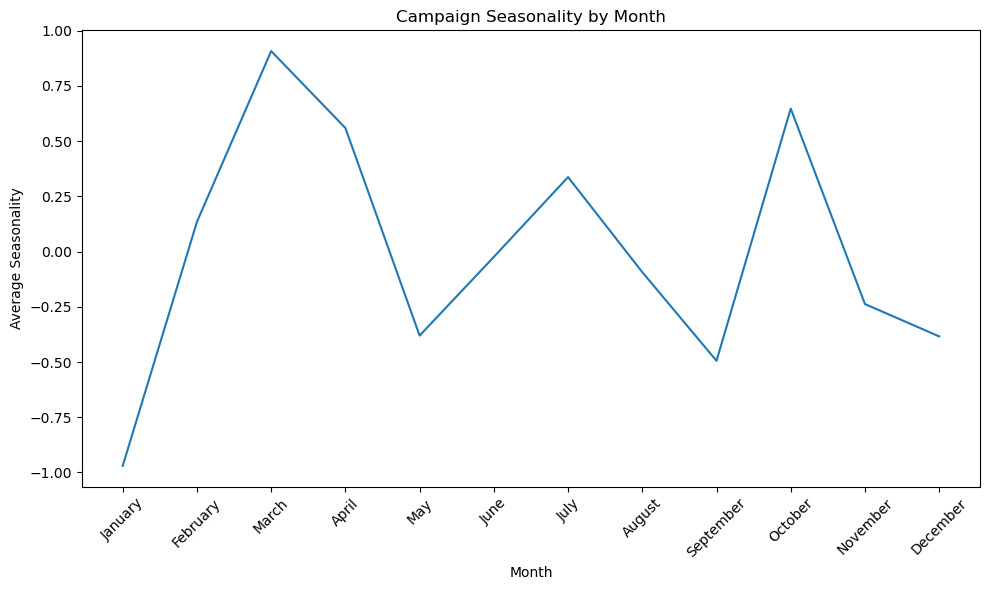

In [93]:
# Calculate average values for each month
monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

# Convert month numbers to month names
month_names = [calendar.month_name[i] for i in monthly_avg.index]

# Plot the line graph with month names as labels
plt.figure(figsize=(10, 6))
plt.plot(month_names, monthly_avg)
plt.title('Campaign Seasonality by Month')
plt.xlabel('Month')
plt.ylabel('Average Seasonality')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [94]:
# Calculate average values for each month
monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

# Convert month numbers to month names
month_names = [calendar.month_name[i] for i in monthly_avg.index]

# Calculate summary statistics
max_seasonality = monthly_avg.max()
min_seasonality = monthly_avg.min()
avg_seasonality = monthly_avg.mean()

# Get the month with the highest and lowest seasonality
month_most_seasonality = month_names[monthly_avg.idxmax() - 1]  # Subtract 1 to match the month index
month_least_seasonality = month_names[monthly_avg.idxmin() - 1]  # Subtract 1 to match the month index

# Create a formatted string for the summary statistics
summary_seasonality = f"Summary Statistics (Average Seasonality):\n" \
                      f"---------------------------------------\n" \
                      f"Month with the highest seasonality: {month_most_seasonality}\n" \
                      f"Month with the lowest seasonality: {month_least_seasonality}\n" \
                      f"Maximum seasonality value: {max_seasonality}\n" \
                      f"Minimum seasonality value: {min_seasonality}\n" \
                      f"Average seasonality value: {avg_seasonality}"

# Print the summary statistics
print(summary_seasonality)

Summary Statistics (Average Seasonality):
---------------------------------------
Month with the highest seasonality: March
Month with the lowest seasonality: January
Maximum seasonality value: 0.9071901531930601
Minimum seasonality value: -0.9697939737910667
Average seasonality value: 3.23815048849004e-17


#### All Manufacturers: Number of Potential Affected Units

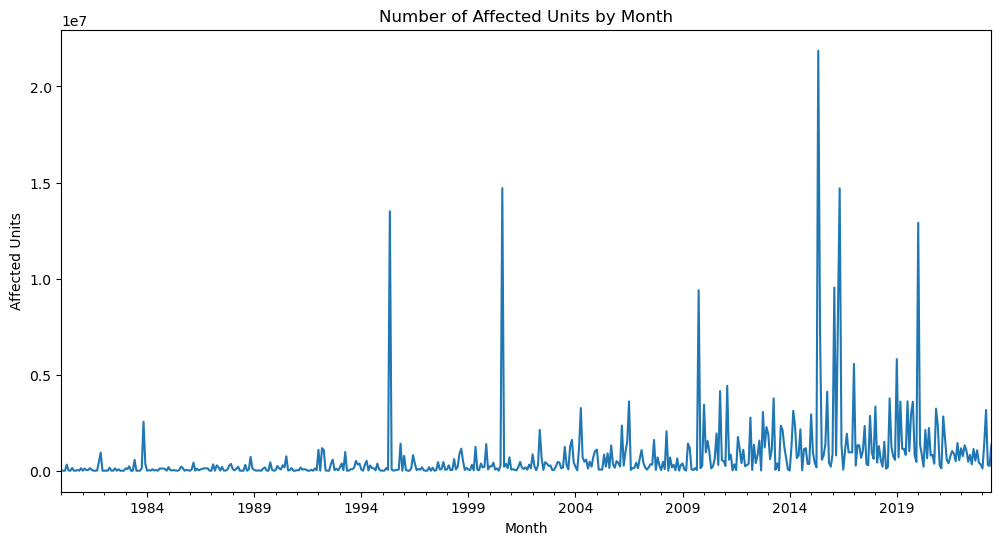

In [96]:
# Group by month and sum the values in the POTAFF column
potaff_by_month = unique_data.groupby(pd.Grouper(key='DATEA', freq='M'))['POTAFF'].sum()

# Plot the time series of recall campaigns
plt.figure(figsize=(12, 6))
potaff_by_month.plot()
plt.title('Number of Affected Units by Month')
plt.xlabel('Month')
plt.ylabel('Affected Units')
plt.show()

In [98]:
# Calculate summary statistics
max_potaff_count = potaff_by_month.max()
min_potaff_count = potaff_by_month.min()
avg_potaff_count = potaff_by_month.mean()
total_potaff_count = potaff_by_month.sum()

# Get the month with the most and least recall campaigns
month_most_potaff = potaff_by_month.idxmax().strftime('%B %Y')
month_least_potaff = potaff_by_month.idxmin().strftime('%B %Y')

# Create a formatted string for the summary statistics
summary_potaff = f"Summary Statistics (Recall POTAFF):\n" \
                    f"-----------------------------------\n" \
                    f"Month with the most recall POTAFF: {month_most_potaff}\n" \
                    f"Month with the least recall POTAFF: {month_least_potaff}\n" \
                    f"Maximum POTAFF: {max_potaff_count}\n" \
                    f"Minimum POTAFF: {min_potaff_count}\n" \
                    f"Average POTAFF: {avg_potaff_count}\n" \
                    f"Total POTAFF count: {total_potaff_count}"

# Print the summary statistics
print(summary_potaff)

Summary Statistics (Recall POTAFF):
-----------------------------------
Month with the most recall POTAFF: May 2015
Month with the least recall POTAFF: June 1980
Maximum POTAFF: 21862009.0
Minimum POTAFF: 0.0
Average POTAFF: 755651.0153256705
Total POTAFF count: 394449830.0


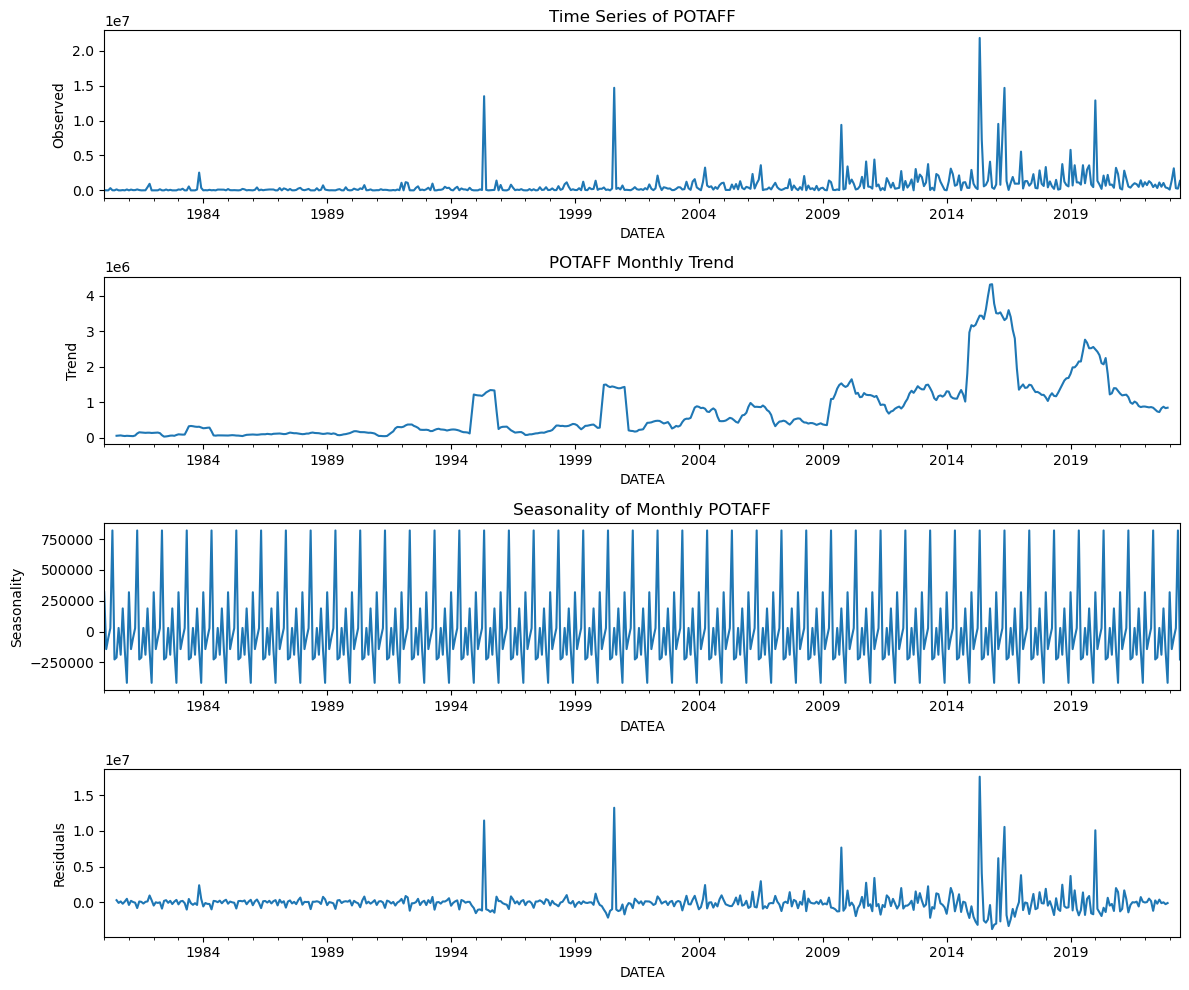

In [99]:
# Perform time series decomposition (trend, seasonality, and residuals)
decomposition = sm.tsa.seasonal_decompose(potaff_by_month, model='additive')

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonality')
decomposition.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residuals')
axes[0].set_title('Time Series of POTAFF')

axes[1].set_title('POTAFF Monthly Trend')

axes[2].set_title('Seasonality of Monthly POTAFF')

plt.tight_layout()
plt.show()

In [100]:
# Calculate summary statistics for the trend component
max_trend = decomposition.trend.max()
min_trend = decomposition.trend.min()
avg_trend = decomposition.trend.mean()
first_non_nan_index = next((i for i, x in list(enumerate(decomposition.trend)) if not np.isnan(x)), None)
last_non_nan_index = next((i for i, x in reversed(list(enumerate(decomposition.trend))) if not np.isnan(x)), None)
first_trend = decomposition.trend.iloc[last_non_nan_index-6] if len(decomposition.trend) > 6 else decompositions.trend.iloc[first_non_nan_index]
last_trend = decomposition.trend.iloc[last_non_nan_index]
trend_direction = "Upwards" if last_trend > first_trend else "Downwards"

# Create a formatted string for the summary statistics
summary_time_series = f"Six Month Trend Statistics:\n" \
                      f"------------------------------\n" \
                      f"Trend:\n" \
                      f"  - Maximum trend value: {max_trend}\n" \
                      f"  - Minimum trend value: {min_trend}\n" \
                      f"  - Average trend value: {avg_trend}\n" \
                      f"  - Trend direction: {trend_direction}"

# Print the summary statistics
print(summary_time_series)

Six Month Trend Statistics:
------------------------------
Trend:
  - Maximum trend value: 4322805.0
  - Minimum trend value: 31045.666666666668
  - Average trend value: 761351.4055555555
  - Trend direction: Upwards


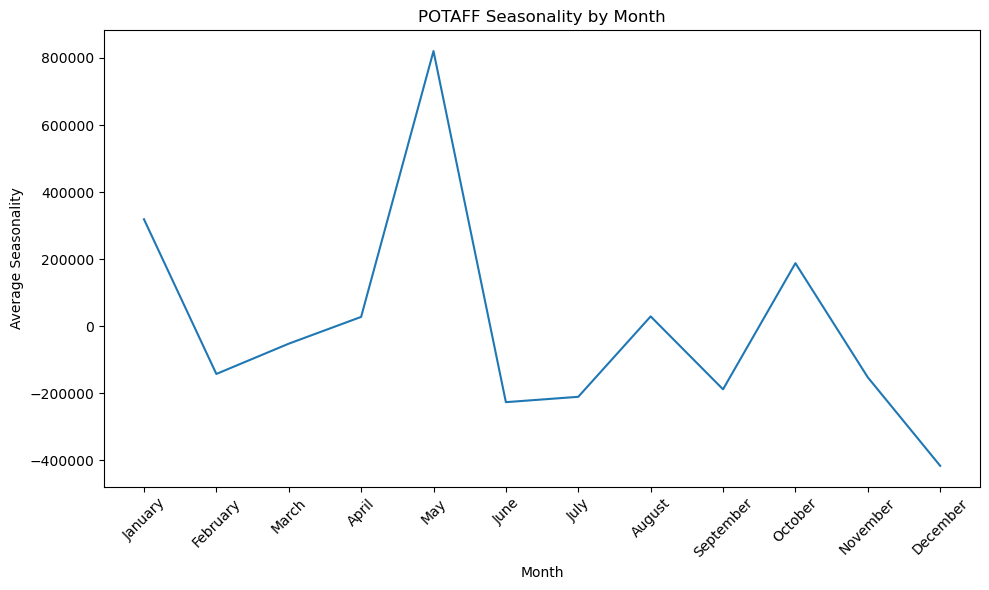

In [101]:
# Calculate average values for each month
monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

# Convert month numbers to month names
month_names = [calendar.month_name[i] for i in monthly_avg.index]

# Plot the line graph with month names as labels
plt.figure(figsize=(10, 6))
plt.plot(month_names, monthly_avg)
plt.title('POTAFF Seasonality by Month')
plt.xlabel('Month')
plt.ylabel('Average Seasonality')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [102]:
# Calculate average values for each month
monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

# Convert month numbers to month names
month_names = [calendar.month_name[i] for i in monthly_avg.index]

# Calculate summary statistics
max_seasonality = monthly_avg.max()
min_seasonality = monthly_avg.min()
avg_seasonality = monthly_avg.mean()

# Get the month with the highest and lowest seasonality
month_most_seasonality = month_names[monthly_avg.idxmax() - 1]  # Subtract 1 to match the month index
month_least_seasonality = month_names[monthly_avg.idxmin() - 1]  # Subtract 1 to match the month index

# Create a formatted string for the summary statistics
summary_seasonality = f"Summary Statistics (Average Seasonality):\n" \
                      f"---------------------------------------\n" \
                      f"Month with the highest seasonality: {month_most_seasonality}\n" \
                      f"Month with the lowest seasonality: {month_least_seasonality}\n" \
                      f"Maximum seasonality value: {max_seasonality}\n" \
                      f"Minimum seasonality value: {min_seasonality}\n" \
                      f"Average seasonality value: {avg_seasonality}"

# Print the summary statistics
print(summary_seasonality)

Summary Statistics (Average Seasonality):
---------------------------------------
Month with the highest seasonality: May
Month with the lowest seasonality: December
Maximum seasonality value: 820647.8365844561
Minimum seasonality value: -415890.2693586963
Average seasonality value: -4.850638409455617e-12


#### Example of a Single Manufacturer

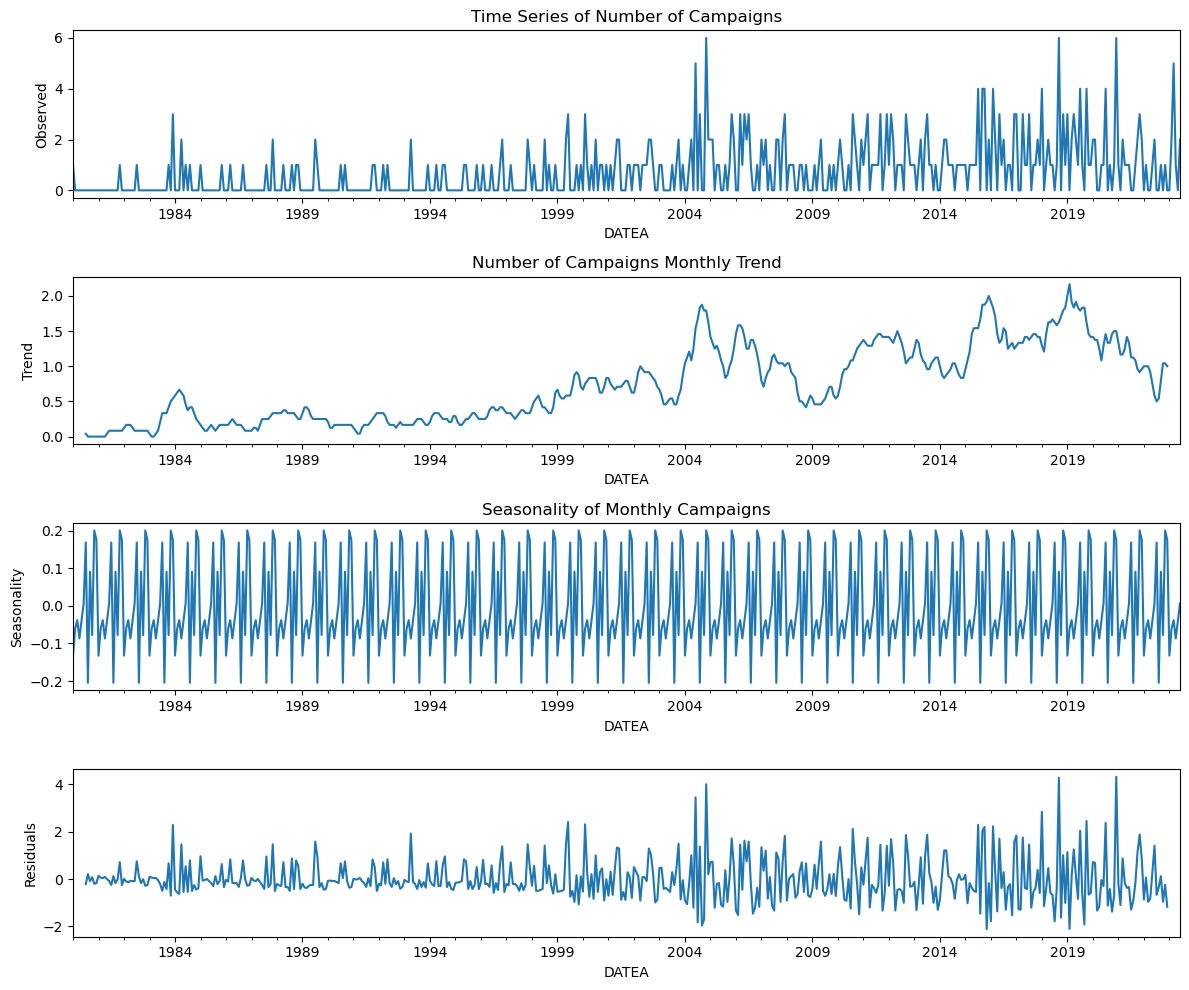

In [103]:
# Group by month and count the number of recall campaigns
campaigns_by_month = unique_data[unique_data['MAKETXT'] == 'HONDA'].groupby(pd.Grouper(key='DATEA', freq='M')).size()

# Perform time series decomposition (trend, seasonality, and residuals)
decomposition = sm.tsa.seasonal_decompose(campaigns_by_month, model='additive')

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonality')
decomposition.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residuals')
axes[0].set_title('Time Series of Number of Campaigns')

axes[1].set_title('Number of Campaigns Monthly Trend')

axes[2].set_title('Seasonality of Monthly Campaigns')
plt.tight_layout()
plt.show()

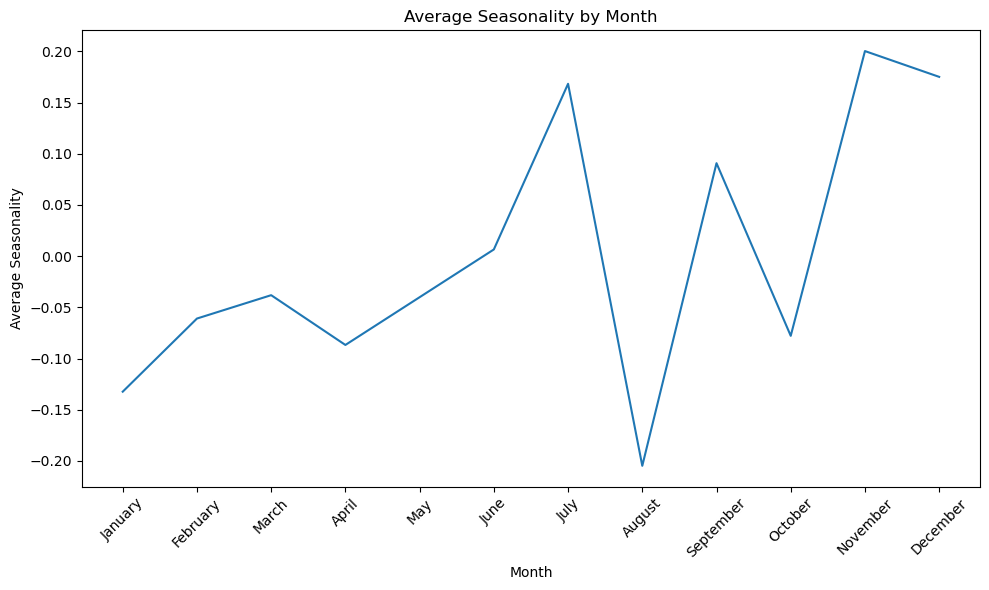

In [104]:
# Calculate average values for each month
monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

# Convert month numbers to month names
month_names = [calendar.month_name[i] for i in monthly_avg.index]

# Plot the line graph with month names as labels
plt.figure(figsize=(10, 6))
plt.plot(month_names, monthly_avg)
plt.title('Average Seasonality by Month')
plt.xlabel('Month')
plt.ylabel('Average Seasonality')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.tight_layout()
plt.show()

#### Generating Table of Summary Statistics by Manufacturer

In [107]:
summary_df = pd.DataFrame(columns = ['Manufacturer','Recent Active Campaigns','Number of Affected Units','Most Active Campaigns','Least Active Campaigns','Highest Single Month POTAFF','Lowest Single Month POTAFF','Most Active Month','Least Active Month','Current Trend'])
for manufacturer in makes:
    try:
        campaigns_by_month = unique_data[unique_data['MAKETXT'] == manufacturer].groupby(pd.Grouper(key='DATEA', freq='M')).size()

        # Calculate summary statistics
        max_campaign_count = campaigns_by_month.max()
        min_campaign_count = campaigns_by_month.min()

        # Perform time series decomposition (trend, seasonality, and residuals)
        decomposition = sm.tsa.seasonal_decompose(campaigns_by_month, model='additive')

        # Calculate average values for each month
        monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

        # Convert month numbers to month names
        month_names = [calendar.month_name[i] for i in monthly_avg.index]

        # Calculate summary statistics
        max_seasonality = monthly_avg.max()
        min_seasonality = monthly_avg.min()

        # Get the month with the highest and lowest seasonality
        month_most_seasonality = month_names[monthly_avg.idxmax() - 1]  # Subtract 1 to match the month index
        month_least_seasonality = month_names[monthly_avg.idxmin() - 1]  # Subtract 1 to match the month index

        # Calculate summary statistics for the trend component
        first_non_nan_index = next((i for i, x in list(enumerate(decomposition.trend)) if not np.isnan(x)), None)
        last_non_nan_index = next((i for i, x in reversed(list(enumerate(decomposition.trend))) if not np.isnan(x)), None)
        first_trend = decomposition.trend.iloc[last_non_nan_index-6] if len(decomposition.trend) > 6 else decompositions.trend.iloc[first_non_nan_index]
        last_trend = decomposition.trend.iloc[last_non_nan_index]
        trend_direction = "Upwards" if last_trend > first_trend else "Downwards"

        # Group by month and sum the values in the POTAFF column
        potaff_by_month = unique_data[unique_data['MAKETXT'] == manufacturer].groupby(pd.Grouper(key='DATEA', freq='M'))['POTAFF'].sum()

        # Calculate summary statistics
        max_potaff_count = potaff_by_month.max()
        min_potaff_count = potaff_by_month.min()

        values = [manufacturer, campaigns_by_month[-1], int(potaff_by_month[-1]), max_campaign_count, min_campaign_count, int(max_potaff_count), int(min_potaff_count), month_most_seasonality, month_least_seasonality, trend_direction]
        summary_df.loc[len(summary_df)] = values
    except:
        values = [manufacturer, '','','','','','','','','']
        summary_df.loc[len(summary_df)] = values
    

In [108]:
summary_df

,Manufacturer,Recent Active Campaigns,Number of Affected Units,Most Active Campaigns,Least Active Campaigns,Highest Single Month POTAFF,Lowest Single Month POTAFF,Most Active Month,Least Active Month,Current Trend
0,BMW,3,11567,9,0,1443526,0,October,January,Upwards
1,NISSAN,2,312,5,0,4063964,0,March,August,Upwards
2,INFINITI,1,82,3,0,3296947,0,May,August,Upwards
3,VOLVO,3,496,6,0,454091,0,October,January,Upwards
4,TOYOTA,1,298,6,0,4861570,0,April,December,Downwards
5,MINI,1,97933,2,0,97933,0,October,February,Upwards
6,AUDI,2,5243,6,0,930000,0,October,November,Upwards
7,KIA,1,98944,4,0,980377,0,April,June,Downwards
8,HONDA,2,1198666,6,0,6281043,0,November,August,Upwards
9,MOPAR,2,8679,3,0,57477,0,November,February,Upwards


## Advanced Methods Prototyping

### Time Series Analysis

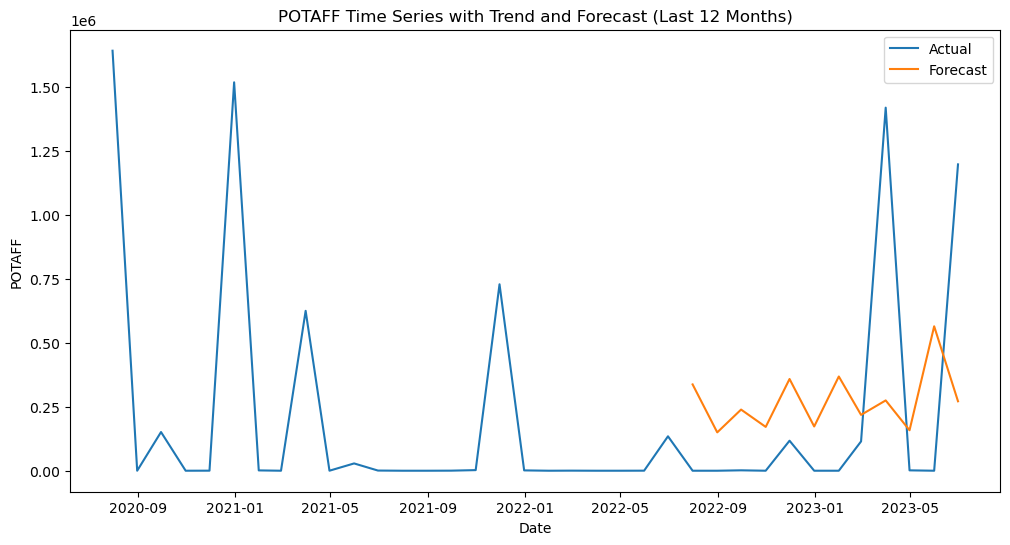

In [112]:
# Convert the potaff_by_month dataframe into a time series
potaff_by_month = unique_data[unique_data['MAKETXT']=='HONDA'].groupby(pd.Grouper(key='DATEA', freq='M'))['POTAFF'].sum()
potaff_ts = pd.Series(potaff_by_month)

# Train the SARIMA model with trend
model = SARIMAX(potaff_ts[:-12], order=(2, 0, 2), seasonal_order=(0, 1, 2, 12), trend='c')
model_fit = model.fit()

# Forecast future values for a year (12 months)
forecast_values = model_fit.forecast(steps=12)

# Plot the time series and forecasted values for the last 12 months
plt.figure(figsize=(12, 6))
plt.plot(potaff_ts.index[-36:], potaff_ts[-36:], label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast')
plt.title('POTAFF Time Series with Trend and Forecast (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('POTAFF')
plt.legend()
plt.show()

In [111]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the range of parameter values to search
p_values = range(0, 3)  # p values (AR)
d_values = range(0, 2)  # d values (I)
q_values = range(0, 3)  # q values (MA)
P_values = range(0, 3)  # seasonal P values (AR)
D_values = range(0, 2)  # seasonal D values (I)
Q_values = range(0, 3)  # seasonal Q values (MA)
s_values = [12]  # seasonal period

# Create a list of all possible parameter combinations
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_aic = float('inf')
best_params = None

# Iterate over each parameter combination
for params in param_combinations:
    order = params[:3]  # ARIMA order
    seasonal_order = params[3:]  # Seasonal order

    try:
        # Fit the SARIMA model with the current parameter combination
        model = SARIMAX(potaff_ts[:-12], order=order, seasonal_order=seasonal_order, trend='c')
        model_fit = model.fit(disp=False)

        # Calculate the Akaike Information Criterion (AIC)
        aic = model_fit.aic

        # Check if the current model has a lower AIC
        if aic < best_aic:
            best_aic = aic
            best_params = params

    except Exception as e:
        # Handle any exceptions that occur during model fitting
        warnings.warn(f"Exception encountered for parameter combination {params}: {e}")

# Print the best parameter combination and AIC value
print("Best Parameter Combination:", best_params)
print("Best AIC:", best_aic)

C:\Users\ryanp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ryanp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ryanp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ryanp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ryanp\anaconda3\lib\s

Best Parameter Combination: (2, 0, 2, 0, 1, 2, 12)
Best AIC: 14529.90055426761


### All Manufacturers: Linear Regression

In [157]:
# Data Preparation
subset_data = relevant_data[['POTAFF', 'MODELTXT', 'MAKETXT', 'YEARTXT', 'BGMAN', 'ENDMAN']]  # Subset relevant columns

# Preprocess the data, handle missing values, convert data types, etc.

# Feature Engineering
# Convert YEARTXT column to numeric format if needed

# Separate features and target variable
X = subset_data.drop('POTAFF', axis=1)  # Features
y = subset_data['POTAFF']  # Target variable

# Perform one-hot encoding for categorical variables (MODELTXT and MAKETXT)
categorical_features = ['MODELTXT', 'MAKETXT']
categorical_transformer = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_features)],
                                            remainder='passthrough')
X_encoded = categorical_transformer.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train the Predictive Model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 308118.4982950526


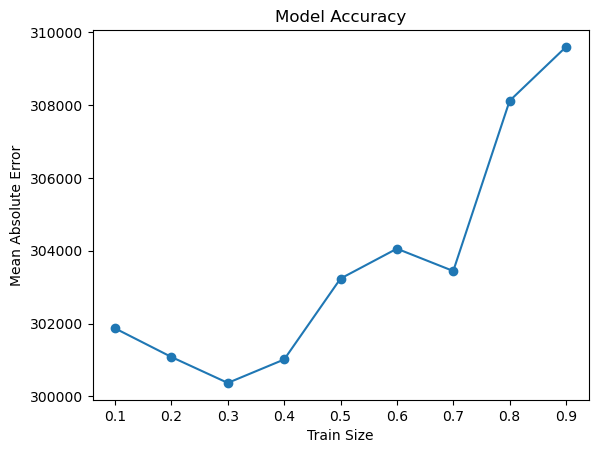

In [160]:
# Define the train sizes to test
train_sizes = np.arange(0.1, 1.0, 0.1)
mae_scores = []

# Iterate over the train sizes
for train_size in train_sizes:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=train_size, random_state=42)
    
    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

# Plot the MAE scores
plt.plot(train_sizes, mae_scores, marker='o')
plt.xlabel('Train Size')
plt.ylabel('Mean Absolute Error')
plt.title('Model Accuracy')
plt.show()

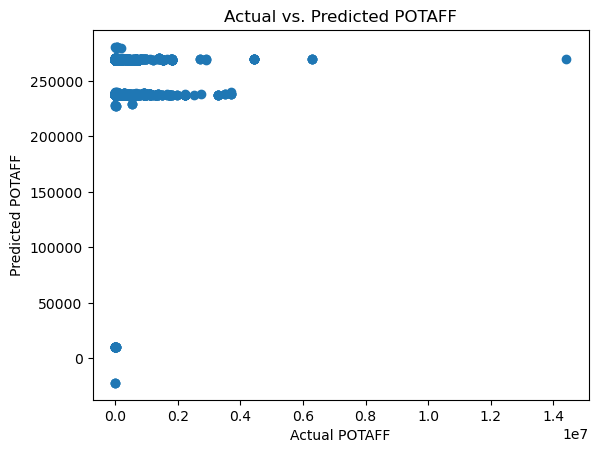

In [159]:
# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual POTAFF')
plt.ylabel('Predicted POTAFF')
plt.title('Actual vs. Predicted POTAFF')
plt.show()

### Individual Manufacturer Models

In [184]:
# Data Preparation
subset_data = relevant_data[['POTAFF', 'MODELTXT', 'MAKETXT', 'YEARTXT', 'BGMAN', 'ENDMAN']]  # Subset relevant columns

# Preprocess the data, handle missing values, convert data types, etc.

# Separate features and target variable
X = subset_data.drop('POTAFF', axis=1)  # Features
y = subset_data['POTAFF']  # Target variable

# Perform one-hot encoding for categorical variables (MODELTXT and MAKETXT)
categorical_features = ['MODELTXT', 'MAKETXT']
categorical_transformer = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_features)],
                                            remainder='passthrough')
X_encoded = categorical_transformer.fit_transform(X)

# Get unique values in MAKETXT
unique_makes = X['MAKETXT'].unique()

# Train and evaluate models for each unique MAKETXT value
models = {}
for make in unique_makes:
    # Subset the data for the current make
    make_indices = X['MAKETXT'] == make
    X_make = X_encoded[make_indices]
    y_make = y[make_indices]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_make, y_make, test_size=0.2, random_state=42)

    # Train the Predictive Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[make] = model

    # Evaluate the Model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error for {make}: {mae}")

Mean Absolute Error for HONDA: 336195.61338825215
Mean Absolute Error for VOLKSWAGEN: 228575.30500828908
Mean Absolute Error for VOLVO: 53207.62498389118
Mean Absolute Error for ACURA: 495053.90102017863
Mean Absolute Error for SUBARU: 130295.30167396458
Mean Absolute Error for NISSAN: 272291.9913930451
Mean Absolute Error for KIA: 153986.75890490893
Mean Absolute Error for INFINITI: 231400.48425680381
Mean Absolute Error for TOYOTA: 413461.60828243813
Mean Absolute Error for HYUNDAI: 264347.0216942269
Mean Absolute Error for MINI: 30302.04695843353
Mean Absolute Error for BMW: 126741.35621050547
Mean Absolute Error for MAZDA: 623940.2645756878
Mean Absolute Error for LEXUS: 659285.2464236713
Mean Absolute Error for LAND ROVER: 9622.874739728564
Mean Absolute Error for AUDI: 42079.990406171506
Mean Absolute Error for JAGUAR: 11610.186112422567
Mean Absolute Error for PORSCHE: 65996.19638818488
Mean Absolute Error for MOPAR: 15739.297814734717
Mean Absolute Error for MERCEDES: 0.0


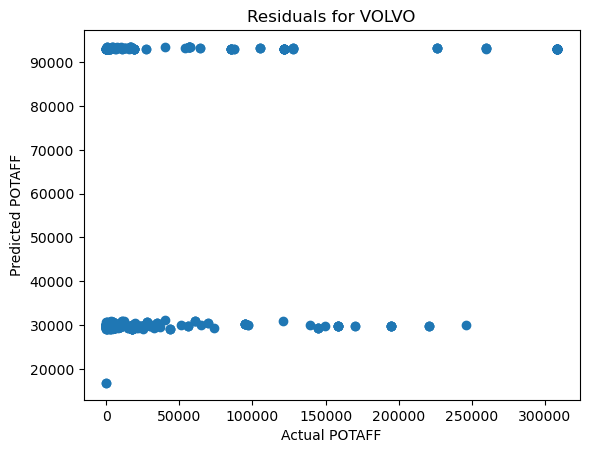

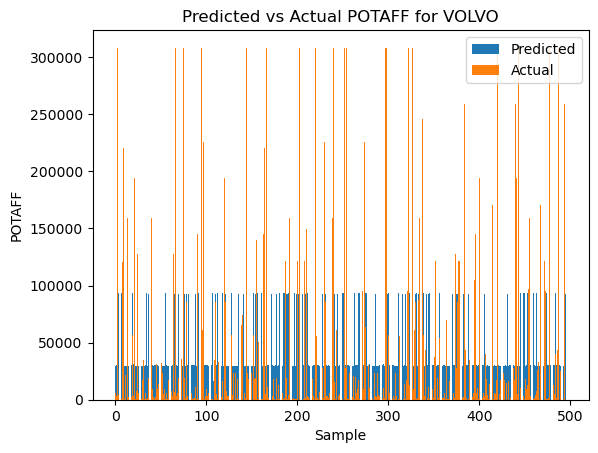

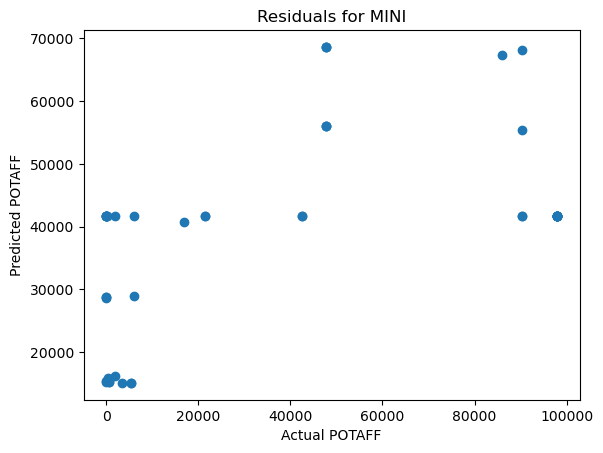

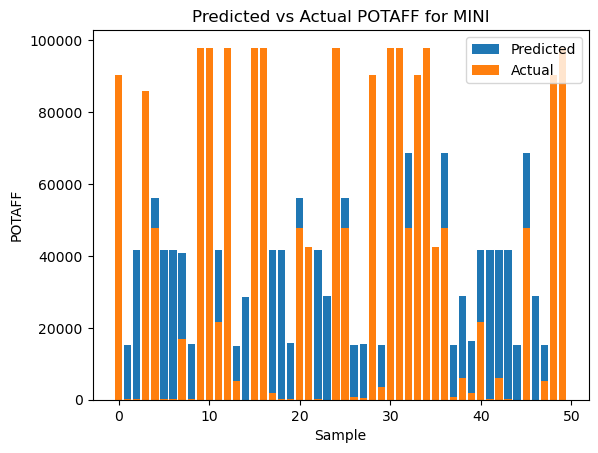

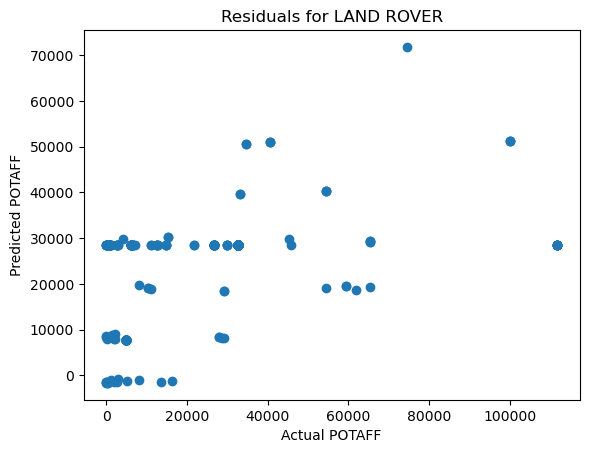

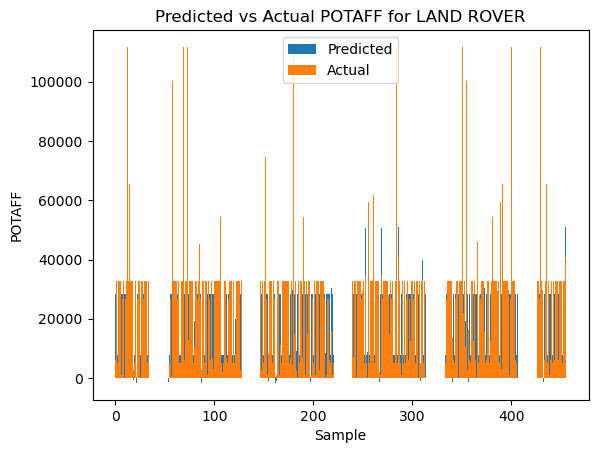

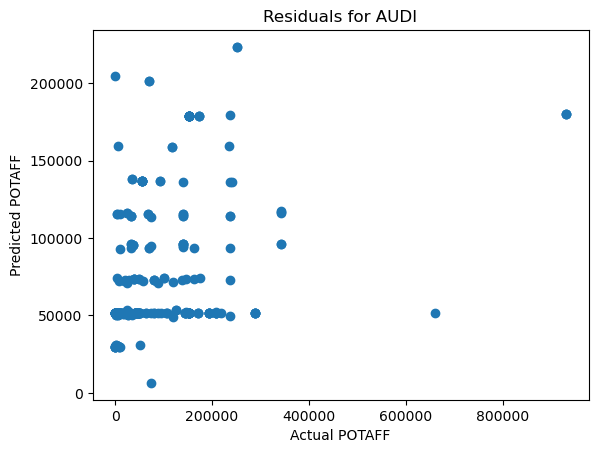

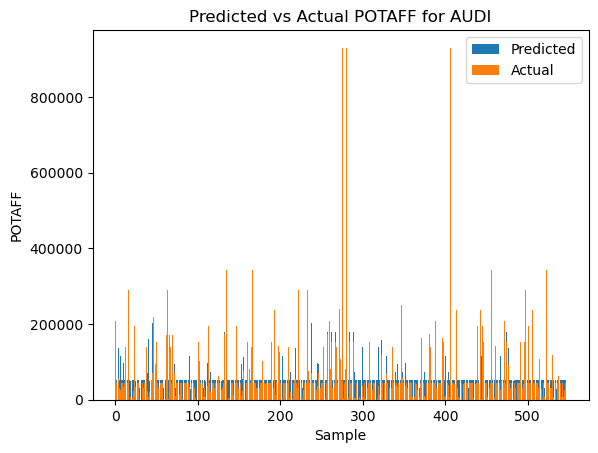

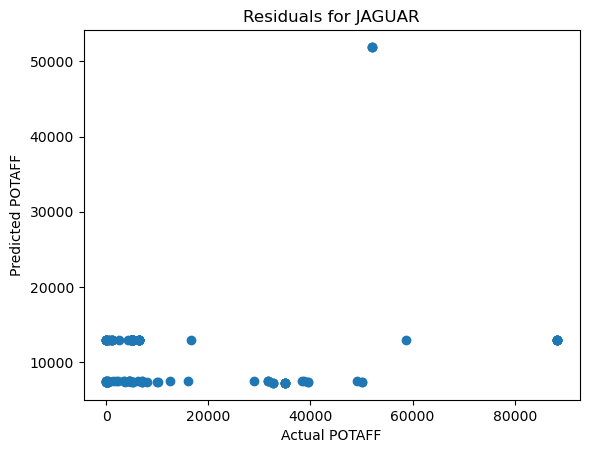

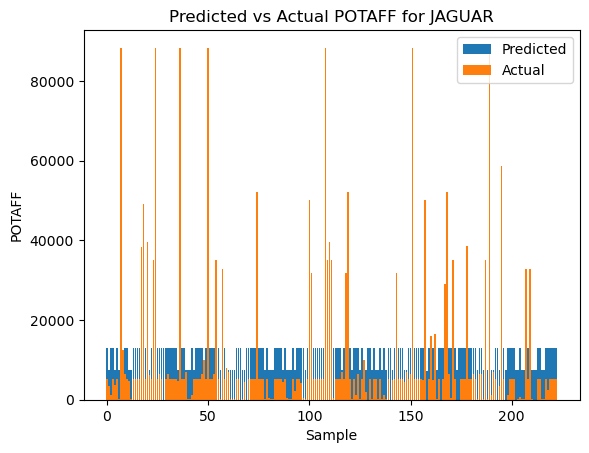

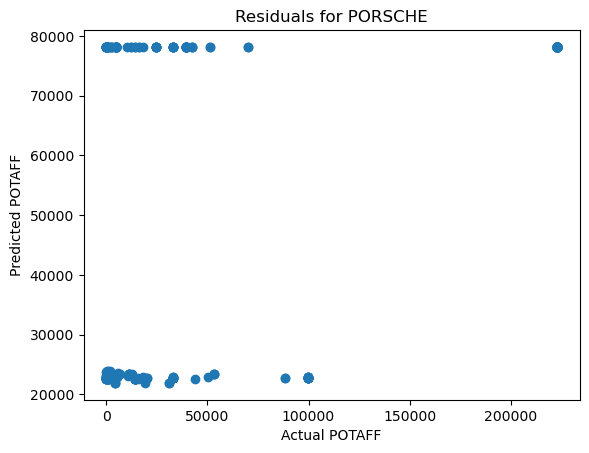

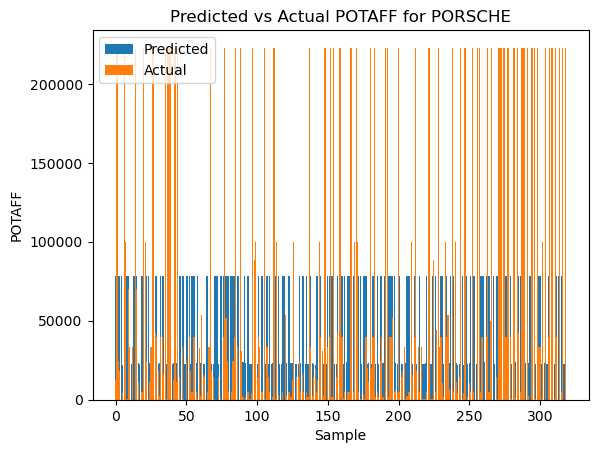

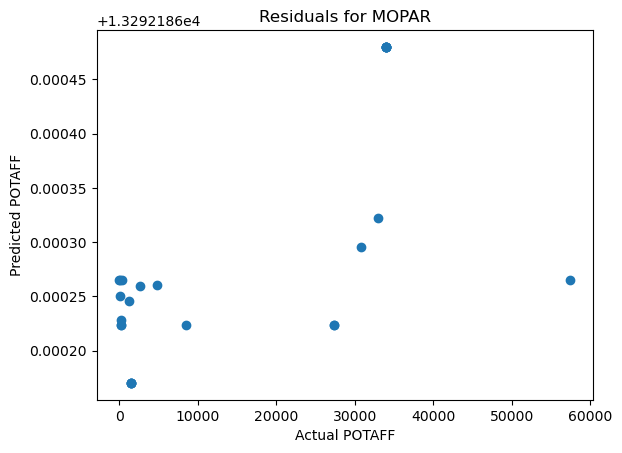

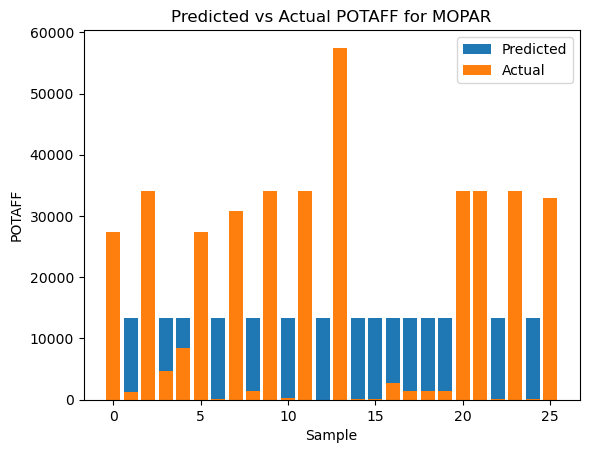

In [185]:
# Data Preparation
subset_data = relevant_data[['POTAFF', 'MODELTXT', 'MAKETXT', 'YEARTXT', 'BGMAN', 'ENDMAN']]  # Subset relevant columns

# Preprocess the data, handle missing values, convert data types, etc.

# Separate features and target variable
X = subset_data.drop('POTAFF', axis=1)  # Features
y = subset_data['POTAFF']  # Target variable

# Perform one-hot encoding for categorical variables (MODELTXT and MAKETXT)
categorical_features = ['MODELTXT', 'MAKETXT']
categorical_transformer = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_features)],
                                            remainder='passthrough')
X_encoded = categorical_transformer.fit_transform(X)

# Get unique values in MAKETXT
makes_of_interest = ['VOLVO', 'MINI', 'LAND ROVER', 'AUDI', 'JAGUAR', 'PORSCHE', 'MOPAR']

# Train and evaluate models for each unique MAKETXT value
models = {}
for make in makes_of_interest:
    # Subset the data for the current make
    make_indices = X['MAKETXT'] == make
    X_make = X_encoded[make_indices]
    y_make = y[make_indices]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_make, y_make, test_size=0.2, random_state=42)

    # Train the Predictive Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[make] = model

    # Evaluate the Model
    y_pred = model.predict(X_test)

    # Plot Residuals
    residuals = y_test - y_pred
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual POTAFF')
    plt.ylabel('Predicted POTAFF')
    plt.title(f'Residuals for {make}')

    # Plot Predicted vs Actual
    plt.figure()
    plt.bar(range(len(y_pred)), y_pred, label='Predicted')
    plt.bar(range(len(y_test)), y_test, label='Actual')
    plt.xlabel('Sample')
    plt.ylabel('POTAFF')
    plt.title(f'Predicted vs Actual POTAFF for {make}')
    plt.legend()

plt.show()

## Repeatable Process: GUI

In [ ]:
# Create a set of unique manufacturers
manufacturers = set(relevant_data['MAKETXT'])

# Create a dictionary to store the filtered data for each manufacturer
filtered_data = {manufacturer: relevant_data[relevant_data['MAKETXT'] == manufacturer] for manufacturer in manufacturers}

bg_color = "#FFDDD6"
fg_color = "white"
accent_color = "black"
graph_color = "#FFEBE7"
line_color1 = "#FB3640"
line_color2 = "#725AC1"

# Create a GUI window
window = tk.Tk()
window.configure(bg=bg_color)
window.title("Recall Dashboard")


# Create a function to update the dashboard
def update_dashboard():
    manufacturer = manufacturer_var.get()
    models = model_listbox.curselection()
    models = [model_listbox.get(idx) for idx in models]
    start_date = start_date_entry.get_date()
    end_date = end_date_entry.get_date()
    campaign = campaign_entry.get()
    

    if manufacturer == 'All':
        # Combine data for all manufacturers
        selected_data = pd.concat(filtered_data.values())
    else:
        selected_data = filtered_data[manufacturer]

    if models:
        selected_data = selected_data[selected_data['MODELTXT'].isin(models)]

    if campaign:
        selected_data = selected_data[selected_data['MFGCAMPNO'] == campaign]

    if start_date and end_date:
        start_date = datetime.combine(start_date, datetime.min.time())
        end_date = datetime.combine(end_date, datetime.max.time())
        selected_data = selected_data[(selected_data['DATEA'] >= start_date) & (selected_data['DATEA'] <= end_date)]
    
    # Drop duplicate rows based on the 'MAKETXT' and 'CAMPNO' columns
    unique_data = selected_data.drop_duplicates(subset=['MAKETXT', 'CAMPNO'])

    # Summarize trends for each manufacturer
    manufacturer_campaign_counts = unique_data.groupby('MAKETXT')['MFGCAMPNO'].nunique()
    manufacturer_vehicle_counts = unique_data.groupby('MAKETXT')['POTAFF'].sum()
    
    # Group by month and count the number of recall campaigns
    campaigns_by_month = unique_data.groupby(pd.Grouper(key='DATEA', freq='M')).size()
    
    # Perform time series decomposition (trend, seasonality, and residuals)
    decomposition = sm.tsa.seasonal_decompose(campaigns_by_month, model='additive')
    
    # Group by month and sum the values in the POTAFF column
    potaff_by_month = unique_data.groupby(pd.Grouper(key='DATEA', freq='M'))['POTAFF'].sum()
        
    # Clear the graph frame
    for widget in graph_frame.winfo_children():
        widget.destroy()

    # Example 1: Stacked bar chart for sales by month
    fig1, ax1 = plt.subplots(figsize=(5, 4))
    manufacturer_campaign_counts.plot(kind='bar', ax=ax1, color=line_color1)
    fig1.set_facecolor(graph_color)
    ax1.set_facecolor(graph_color)
    ax1.set_title('Number of Campaigns by Manufacturer')
    ax1.set_xlabel('Manufacturer')
    ax1.set_ylabel('Campaign Count')

    canvas1 = FigureCanvasTkAgg(fig1, master=graph_frame)
    canvas1.draw()
    canvas1.get_tk_widget().grid(row=0, column=0, padx=0, pady=10, sticky='nsew')

    # Create a label for the first graph
    # Calculate summary statistics
    max_count = manufacturer_campaign_counts.max()
    min_count = manufacturer_campaign_counts.min()
    avg_count = manufacturer_campaign_counts.mean()

    # Get manufacturers with the most and least campaign counts
    manufacturer_most = manufacturer_campaign_counts.idxmax()
    manufacturer_least = manufacturer_campaign_counts.idxmin()

    # Create a formatted string for the summary statistics
    text1 = f"Summary Statistics:\n" \
          f"------------------------------\n" \
          f"Manufacturer with the most campaigns: {manufacturer_most}\n" \
          f"Manufacturer with the least campaigns: {manufacturer_least}\n" \
          f"Maximum campaign count: {max_count}\n" \
          f"Minimum campaign count: {min_count}\n" \
          f"Average campaign count: {avg_count}"
    text_widget1 = tk.Label(graph_frame, text=text1, bg=fg_color, fg=accent_color)
    text_widget1.grid(row=1, column=0, padx=0, pady=10, sticky='w'+'e')

    # Example 2: Line chart for total recalls by month
    fig2, ax2 = plt.subplots(figsize=(5, 4))
    manufacturer_vehicle_counts.plot(kind='bar', ax=ax2, color=line_color1)
    fig2.set_facecolor(graph_color)
    ax2.set_facecolor(graph_color)
    plt.title('Number of Vehicles Affected by Manufacturer')
    plt.xlabel('Manufacturer')
    plt.ylabel('Vehicle Count')
    plt.show()

    canvas2 = FigureCanvasTkAgg(fig2, master=graph_frame)
    canvas2.draw()
    canvas2.get_tk_widget().grid(row=0, column=1, padx=0, pady=10, sticky='nsew')

    # Create a label for the second graph
    # Calculate summary statistics
    max_vehicle_count = manufacturer_vehicle_counts.max()
    min_vehicle_count = manufacturer_vehicle_counts.min()
    avg_vehicle_count = manufacturer_vehicle_counts.mean()

    # Get manufacturers with the most and least vehicle counts
    manufacturer_most_vehicles = manufacturer_vehicle_counts.idxmax()
    manufacturer_least_vehicles = manufacturer_vehicle_counts.idxmin()

    # Create a formatted string for the summary statistics
    text2 = f"Summary Statistics (Vehicles):\n" \
                       f"------------------------------\n" \
                       f"Manufacturer with the most vehicles affected: {manufacturer_most_vehicles}\n" \
                       f"Manufacturer with the least vehicles affected: {manufacturer_least_vehicles}\n" \
                       f"Maximum vehicle count: {max_vehicle_count}\n" \
                       f"Minimum vehicle count: {min_vehicle_count}\n" \
                       f"Average vehicle count: {avg_vehicle_count}"
    text_widget2 = tk.Label(graph_frame, text=text2, bg=fg_color, fg=accent_color)
    text_widget2.grid(row=1, column=1, padx=0, pady=10, sticky='w'+'e')

    # Example 3: Pie chart for model distribution
    fig3, ax3 = plt.subplots(figsize=(5, 4))
    fig3.set_facecolor(graph_color)
    ax3.set_facecolor(graph_color)
    model_counts = selected_data['MODELTXT'].value_counts()

    # Set a threshold value for small slices
    threshold = 0.05  # Adjust this value as needed

    # Get the total count of models
    total_count = model_counts.sum()

    # Identify the small slices below the threshold
    small_slices = model_counts[model_counts / total_count < threshold]

    # Combine small slices into a single group
    combined_count = small_slices.sum()
    combined_label = f"Combined ({len(small_slices)} models)"
    combined_models = list(small_slices.index)

    # Create a new series without the small slices
    filtered_counts = model_counts[~model_counts.index.isin(small_slices.index)]

    # Add the combined group to the filtered counts
    filtered_counts[combined_label] = combined_count

    # Plot the pie chart with the filtered counts
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#77DD77','#aaf0d1','#bdb0d0','#ff6961','#ff694f']
    wedges, texts, autotexts = ax3.pie(filtered_counts.values, labels=filtered_counts.index, autopct='%1.1f%%', colors = colors)

    ax3.set_title('Model Distribution')
    
    fig3.subplots_adjust(left=-0.001)

    plt.show()

    canvas3 = FigureCanvasTkAgg(fig3, master=graph_frame)
    canvas3.draw()
    canvas3.get_tk_widget().grid(row=0, column=2, padx=0, pady=10, sticky='nsew')

    # Create a label for the third graph
    # Calculate the count for each model
    counts = filtered_counts

    # Calculate the model with the highest and lowest counts
    model_most_common = counts.idxmax()
    model_least_common = counts.idxmin()

    # Create a formatted string for the summary statistics
    text3 = f"Summary Statistics (Models):\n" \
                     f"----------------------------\n" \
                     f"Model with the highest count: {model_most_common}\n" \
                     f"Model with the lowest count: {model_least_common}\n" \
                     f"Number of models: {len(filtered_counts)}\n" \
                     f"Total count of models: {total_count}\n"
    text_widget3 = tk.Label(graph_frame, text=text3, bg=fg_color, fg=accent_color)
    text_widget3.grid(row=1, column=2, padx=0, pady=10, sticky='w'+'e')

    
    
    # Plot the time series of recall campaigns
    fig4, ax4 = plt.subplots(figsize=(5, 4))
    campaigns_by_month.plot(ax=ax4, color=line_color1)
    fig4.set_facecolor(graph_color)
    ax4.set_facecolor(graph_color)
    plt.title('Number of Recall Campaigns by Month')
    plt.xlabel('Month')
    plt.ylabel('Campaign Count')
    plt.show()
    
    canvas4 = FigureCanvasTkAgg(fig4, master=graph_frame)
    canvas4.draw()
    canvas4.get_tk_widget().grid(row=2, column=0, padx=0, pady=10, sticky='nsew')
    
    # Create a label for the fourth graph
    # Calculate summary statistics
    max_campaign_count = campaigns_by_month.max()
    min_campaign_count = campaigns_by_month.min()
    avg_campaign_count = campaigns_by_month.mean()
    total_campaign_count = campaigns_by_month.sum()

    # Get the month with the most and least recall campaigns
    month_most_campaigns = campaigns_by_month.idxmax().strftime('%B %Y')
    month_least_campaigns = campaigns_by_month.idxmin().strftime('%B %Y')

    # Create a formatted string for the summary statistics
    text4 = f"Summary Statistics (Recall Campaigns):\n" \
                        f"-----------------------------------\n" \
                        f"Month with the most recall campaigns: {month_most_campaigns}\n" \
                        f"Month with the least recall campaigns: {month_least_campaigns}\n" \
                        f"Maximum active campaign count: {max_campaign_count}\n" \
                        f"Minimum active campaign count: {min_campaign_count}\n" \
                        f"Average active campaign count: {avg_campaign_count}\n" \
                        f"Total campaign count: {total_campaign_count}"
    text_widget4 = tk.Label(graph_frame, text=text4, bg=fg_color, fg=accent_color)
    text_widget4.grid(row=3, column=0, padx=0, pady=10, sticky='w'+'e')
    
    
    
    # Plot the time series trend of recall campaigns
    fig5, ax5 = plt.subplots(figsize=(5, 4))
    decomposition.trend.plot(ax=ax5, color=line_color1)
    fig5.set_facecolor(graph_color)
    ax5.set_facecolor(graph_color)
    ax5.set_title('Trend of Number of Campaigns')
    ax5.set_ylabel('General Trend')
    plt.show()
    
    canvas5 = FigureCanvasTkAgg(fig5, master=graph_frame)
    canvas5.draw()
    canvas5.get_tk_widget().grid(row=2, column=1, padx=0, pady=10, sticky='nsew')
    
    # Create a label for the fourth graph
    # Calculate summary statistics for the trend component
    max_trend = decomposition.trend.max()
    min_trend = decomposition.trend.min()
    avg_trend = decomposition.trend.mean()
    first_non_nan_index = next((i for i, x in list(enumerate(decomposition.trend)) if not np.isnan(x)), None)
    last_non_nan_index = next((i for i, x in reversed(list(enumerate(decomposition.trend))) if not np.isnan(x)), None)
    first_trend = decomposition.trend.iloc[last_non_nan_index-6] if len(decomposition.trend) > 6 else decompositions.trend.iloc[first_non_nan_index]
    last_trend = decomposition.trend.iloc[last_non_nan_index]
    trend_direction = "Upwards" if last_trend > first_trend else "Downwards"

    # Create a formatted string for the summary statistics
    text5 = f"Six Month Trend Statistics:\n" \
                          f"------------------------------\n" \
                          f"Trend:\n" \
                          f"  - Maximum trend value: {max_trend}\n" \
                          f"  - Minimum trend value: {min_trend}\n" \
                          f"  - Average trend value: {avg_trend}\n" \
                          f"  - Trend direction: {trend_direction}"
    text_widget5 = tk.Label(graph_frame, text=text5, bg=fg_color, fg=accent_color)
    text_widget5.grid(row=3, column=1, padx=0, pady=10, sticky='w'+'e')
    
    
    # Plot the time series seasonality of recall campaigns
    fig6, ax6 = plt.subplots(figsize=(5, 4))
    decomposition.seasonal.plot(ax=ax6, color=line_color1)
    fig6.set_facecolor(graph_color)
    ax6.set_facecolor(graph_color)
    ax6.set_title('Seasonality of Number of Campaigns')
    ax6.set_ylabel('Average Seasonality')
    plt.show()
    
    canvas6 = FigureCanvasTkAgg(fig6, master=graph_frame)
    canvas6.draw()
    canvas6.get_tk_widget().grid(row=2, column=2, padx=0, pady=10, sticky='nsew')
    
    # Create a label for the fourth graph
    # Calculate average values for each month
    monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

    # Convert month numbers to month names
    month_names = [calendar.month_name[i] for i in monthly_avg.index]

    # Calculate summary statistics
    max_seasonality = monthly_avg.max()
    min_seasonality = monthly_avg.min()
    avg_seasonality = monthly_avg.mean()

    # Get the month with the highest and lowest seasonality
    month_most_seasonality = month_names[monthly_avg.idxmax() - 1]  # Subtract 1 to match the month index
    month_least_seasonality = month_names[monthly_avg.idxmin() - 1]  # Subtract 1 to match the month index

    # Create a formatted string for the summary statistics
    text6 = f"Summary Statistics (Average Seasonality):\n" \
                          f"---------------------------------------\n" \
                          f"Month with the highest seasonality: {month_most_seasonality}\n" \
                          f"Month with the lowest seasonality: {month_least_seasonality}\n" \
                          f"Maximum seasonality value: {max_seasonality}\n" \
                          f"Minimum seasonality value: {min_seasonality}\n" \
                          f"Average seasonality value: {avg_seasonality}"
    text_widget6 = tk.Label(graph_frame, text=text6, bg=fg_color, fg=accent_color)
    text_widget6.grid(row=3, column=2, padx=0, pady=10, sticky='w'+'e')
    
    
    # Plot the time series seasonality of recall campaigns
    fig7, ax7 = plt.subplots(figsize=(5, 4))
    potaff_by_month.plot(ax=ax7, color=line_color1)
    fig7.set_facecolor(graph_color)
    ax7.set_facecolor(graph_color)
    ax7.set_title('Number of Affected Units by Month')
    ax7.set_xlabel('Month')
    ax7.set_ylabel('Affected Units')
    plt.show()
    
    canvas7 = FigureCanvasTkAgg(fig7, master=graph_frame)
    canvas7.draw()
    canvas7.get_tk_widget().grid(row=4, column=0, padx=0, pady=10, sticky='nsew')
    
    # Create a label for the fourth graph
    # Calculate summary statistics
    max_potaff_count = potaff_by_month.max()
    min_potaff_count = potaff_by_month.min()
    avg_potaff_count = potaff_by_month.mean()
    total_potaff_count = potaff_by_month.sum()

    # Get the month with the most and least recall campaigns
    month_most_potaff = potaff_by_month.idxmax().strftime('%B %Y')
    month_least_potaff = potaff_by_month.idxmin().strftime('%B %Y')

    # Create a formatted string for the summary statistics
    text7 = f"Summary Statistics (Recall POTAFF):\n" \
                        f"-----------------------------------\n" \
                        f"Month with the most recall POTAFF: {month_most_potaff}\n" \
                        f"Month with the least recall POTAFF: {month_least_potaff}\n" \
                        f"Maximum POTAFF: {max_potaff_count}\n" \
                        f"Minimum POTAFF: {min_potaff_count}\n" \
                        f"Average POTAFF: {avg_potaff_count}\n" \
                        f"Total campaign count: {total_potaff_count}"
    text_widget7 = tk.Label(graph_frame, text=text7, bg=fg_color, fg=accent_color)
    text_widget7.grid(row=5, column=0, padx=0, pady=10, sticky='w'+'e')
    
    
    
    
    # Perform time series decomposition (trend, seasonality, and residuals)
    decomposition = sm.tsa.seasonal_decompose(potaff_by_month, model='additive')    
    
    # Plot the time series seasonality of recall campaigns
    fig8, ax8 = plt.subplots(figsize=(5, 4))
    decomposition.trend.plot(ax=ax8, color=line_color1)
    fig8.set_facecolor(graph_color)
    ax8.set_facecolor(graph_color)
    ax8.set_title('Trend of Number of Affected Units')
    ax8.set_xlabel('Month')
    ax8.set_ylabel('General Trend')
    plt.show()
    
    canvas8 = FigureCanvasTkAgg(fig8, master=graph_frame)
    canvas8.draw()
    canvas8.get_tk_widget().grid(row=4, column=1, padx=0, pady=10, sticky='nsew')
    
    # Create a label for the fourth graph
    # Calculate summary statistics for the trend component
    max_trend = decomposition.trend.max()
    min_trend = decomposition.trend.min()
    avg_trend = decomposition.trend.mean()
    first_non_nan_index = next((i for i, x in list(enumerate(decomposition.trend)) if not np.isnan(x)), None)
    last_non_nan_index = next((i for i, x in reversed(list(enumerate(decomposition.trend))) if not np.isnan(x)), None)
    first_trend = decomposition.trend.iloc[last_non_nan_index-6] if len(decomposition.trend) > 6 else decompositions.trend.iloc[first_non_nan_index]
    last_trend = decomposition.trend.iloc[last_non_nan_index]
    trend_direction = "Upwards" if last_trend > first_trend else "Downwards"

    # Create a formatted string for the summary statistics
    text8 = f"Six Month Trend Statistics:\n" \
                          f"------------------------------\n" \
                          f"Trend:\n" \
                          f"  - Maximum trend value: {max_trend}\n" \
                          f"  - Minimum trend value: {min_trend}\n" \
                          f"  - Average trend value: {avg_trend}\n" \
                          f"  - Trend direction: {trend_direction}"
    text_widget8 = tk.Label(graph_frame, text=text8, bg=fg_color, fg=accent_color)
    text_widget8.grid(row=5, column=1, padx=0, pady=10, sticky='w'+'e')
    
    # Plot the time series seasonality of recall campaigns
    fig9, ax9 = plt.subplots(figsize=(5, 4))
    decomposition.seasonal.plot(ax=ax9, color=line_color1)
    fig9.set_facecolor(graph_color)
    ax9.set_facecolor(graph_color)
    ax9.set_title('Seasonality Number of Affected Units')
    ax9.set_xlabel('Month')
    ax9.set_ylabel('Average Seasonality')
    plt.show()
    
    canvas9 = FigureCanvasTkAgg(fig9, master=graph_frame)
    canvas9.draw()
    canvas9.get_tk_widget().grid(row=4, column=2, padx=0, pady=10, sticky='nsew')
    
    # Create a label for the fourth graph
    # Calculate average values for each month
    monthly_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()

    # Convert month numbers to month names
    month_names = [calendar.month_name[i] for i in monthly_avg.index]

    # Calculate summary statistics
    max_seasonality = monthly_avg.max()
    min_seasonality = monthly_avg.min()
    avg_seasonality = monthly_avg.mean()

    # Get the month with the highest and lowest seasonality
    month_most_seasonality = month_names[monthly_avg.idxmax() - 1]  # Subtract 1 to match the month index
    month_least_seasonality = month_names[monthly_avg.idxmin() - 1]  # Subtract 1 to match the month index

    # Create a formatted string for the summary statistics
    text9 = f"Summary Statistics (Average Seasonality):\n" \
                          f"---------------------------------------\n" \
                          f"Month with the highest seasonality: {month_most_seasonality}\n" \
                          f"Month with the lowest seasonality: {month_least_seasonality}\n" \
                          f"Maximum seasonality value: {max_seasonality}\n" \
                          f"Minimum seasonality value: {min_seasonality}\n" \
                          f"Average seasonality value: {avg_seasonality}"
    text_widget9 = tk.Label(graph_frame, text=text9, bg=fg_color, fg=accent_color)
    text_widget9.grid(row=5, column=2, padx=0, pady=10, sticky='w'+'e')    
    
    # Plot the time series seasonality of recall campaigns
    # Convert the potaff_by_month dataframe into a time series
    potaff_ts = pd.Series(potaff_by_month)
    fig10, ax10 = plt.subplots(figsize=(5, 4))

    # Train the SARIMA model with trend
    model = SARIMAX(potaff_ts, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12), trend='c')
    model_fit = model.fit()

    # Forecast future values for a year (12 months)
    forecast_values = model_fit.forecast(steps=12)

    # Plot the time series and forecasted values for the last 12 months
    fig10, ax10 = plt.subplots(figsize=(5, 4))
    fig10.set_facecolor(graph_color)
    ax10.set_facecolor(graph_color)
    plt.plot(potaff_ts.index[-60:], potaff_ts[-60:], label='Actual', color=line_color1)
    plt.plot(forecast_values.index, forecast_values, label='Forecast', color=line_color2)
    plt.title('POTAFF Time Series with Trend and Forecast (Last 12 Months)')
    plt.xlabel('Date')
    plt.ylabel('POTAFF')
    plt.legend()
    plt.show()
    
    canvas10 = FigureCanvasTkAgg(fig10, master=graph_frame)
    canvas10.draw()
    canvas10.get_tk_widget().grid(row=6, column=0, columnspan=3, padx=0, pady=10, sticky='nsew')
    
# Create a frame to hold the filters
filter_frame = tk.Frame(window, bg = bg_color)
filter_frame.pack(side=tk.TOP, pady=10)

# Create a trace callback function for the manufacturer selection
def manufacturer_selected(*args):
    selected_manufacturer = manufacturer_var.get()

    # Update the model listbox based on the selected manufacturer
    model_listbox.delete(0, tk.END)  # Clear the current options

    if selected_manufacturer == 'All':
        models = data['MODELTXT'].unique().tolist()
    else:
        models = filtered_data[selected_manufacturer]['MODELTXT'].unique().tolist()

    for model in models:
        model_listbox.insert(tk.END, model)

# Create a drop-down menu for manufacturer selection
manufacturer_var = tk.StringVar(window)
manufacturer_var.set('All')
manufacturer_menu = ttk.OptionMenu(filter_frame, manufacturer_var, 'All', *manufacturers)
manufacturer_menu.pack(side=tk.LEFT, padx=10)

# Add the trace callback to the manufacturer variable
manufacturer_var.trace('w', manufacturer_selected)

# Create a label for the model selection
model_label = tk.Label(filter_frame, text="Select Model(s):")
model_label.pack(side=tk.LEFT, padx=10)

# Create a listbox for model selection
model_var = tk.StringVar(window)
model_listbox = Listbox(filter_frame, listvariable=model_var, selectmode='multiple', height=5, exportselection=False)
model_listbox.pack(side=tk.LEFT, padx=10)

# Function to update the model listbox options
def update_model_listbox():
    selected_manufacturer = manufacturer_var.get()

    model_listbox.delete(0, tk.END)  # Clear the current options

    if selected_manufacturer == 'All':
        models = data['MODELTXT'].unique().tolist()
    else:
        models = filtered_data[selected_manufacturer]['MODELTXT'].unique().tolist()

    for model in models:
        model_listbox.insert(tk.END, model)

# Call the update_model_listbox function initially to populate the options
update_model_listbox()

# Create a label for the date range selection
date_label = tk.Label(filter_frame, text="Select Date Range:")
date_label.pack(side=tk.LEFT, padx=10)

# Create date entry widgets for start and end dates
start_date_entry = DateEntry(filter_frame, width=12, background='darkblue', foreground='white', date_pattern='yyyy-mm-dd')
start_date_entry.pack(side=tk.LEFT, padx=10)

end_date_entry = DateEntry(filter_frame, width=12, background='darkblue', foreground='white', date_pattern='yyyy-mm-dd')
end_date_entry.pack(side=tk.LEFT, padx=10)

# Create a label for the campaign filter
campaign_label = Label(filter_frame, text="Campaign:")
campaign_label.pack(side=tk.LEFT, padx=10)

# Create an entry widget for the campaign filter
campaign_entry = Entry(filter_frame)
campaign_entry.pack(side=tk.LEFT, padx=10)

# Create a button to update the dashboard
update_button = ttk.Button(filter_frame, text="Update", command=update_dashboard)
update_button.pack(side=tk.RIGHT, padx=10)

# Create a frame to hold the canvas and scrollbar
canvas_frame = tk.Frame(window, bg=accent_color)
canvas_frame.pack(fill=tk.BOTH, expand=True)

# Create a canvas to hold the graph_frame
canvas = tk.Canvas(canvas_frame, bg=bg_color)
canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# Create a scrollbar for the canvas
scrollbar = tk.Scrollbar(canvas_frame, orient=tk.VERTICAL, command=canvas.yview,bg=accent_color)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# Configure the canvas to use the scrollbar
canvas.configure(yscrollcommand=scrollbar.set)
canvas.bind('<Configure>', lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

# Create a frame inside the canvas to hold the graphs
graph_frame = tk.Frame(canvas,bg=fg_color)

# Add the graph_frame to the canvas
canvas.create_window((0, 0), window=graph_frame, anchor="nw")

# Run the GUI event loop
window.mainloop()